In [2]:
%matplotlib inline
%load_ext tensorboard

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-22 12:18:16.930397: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [5]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [7]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
from config import *
import json

In [8]:
def intervalToMilliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
        None if unit not one of m, h, d or w
        None if string not in correct format
        int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms= int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

In [9]:
path = "18-01-01-00-00-23-05-20-05-55-1h" #

table = np.load( os.path.join( Config['BinanceCandlesNumpy'], "table-" + path + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (47137, 336, 10)


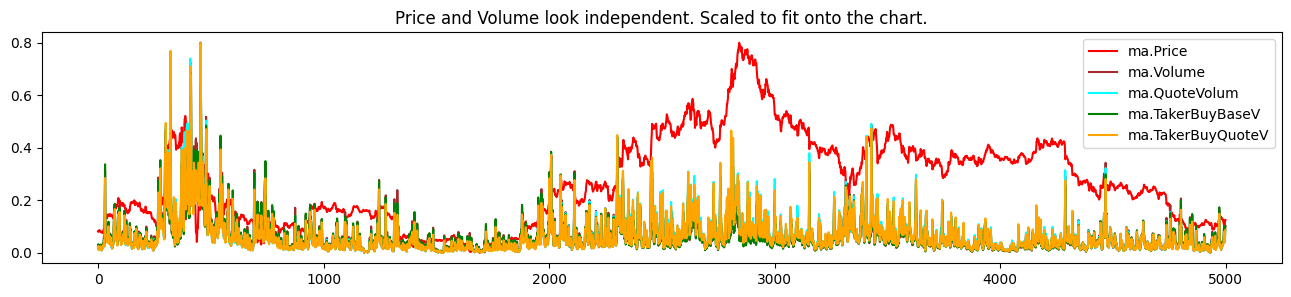

In [10]:
from Mike_NB_01 import *

market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

In [11]:
marks = table[:, :, 9] # keep it for later use

table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, Marks

from enum import Enum
class Fields(Enum):
    Close = 0       # closing price
    Volume = 1      # base volume
    bVolume = 2     # buyer base volume

table_markets = []
with open( os.path.join( Config['BinanceCandlesNumpy'], "reports-" + path + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 47137, 28074 created. Success.', 'DOTUSDT: 47137, 23082 created. Success.']
(47137, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [12]:
# Add time features

start = datetime( 2000+int(path[0:2]), int(path[3:5]), int(path[6:8]), int(path[9:11]), int(path[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = path[ path.find('-', len(path) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps = np.array( range(start_ts, start_ts + table.shape[1] * interval_s, interval_s), dtype=int)
assert timestamps.shape[0] == table.shape[1]
print(start_ts, interval_s, timestamps.shape, timestamps[:3])

# A normalized representation of 'timestamps'
time_of_year_sin = np.sign( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_year_cos = np.cos( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_week_sin = np.sign( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_week_cos = np.cos( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_day_sin = np.sign( 2 * np.pi / (60*60*24) * timestamps )
time_of_day_cos = np.cos( 2 * np.pi / (60*60*24) * timestamps )

1514764800 3600 (336,) [1514764800 1514768400 1514772000]


In [13]:
# # Find market clusters
# from sklearn.metrics import pairwise

# distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# # Find dependency distance
# for m in range(table.shape[1]):
#     distances[m, m] = 0.
#     for n in range(m+1, table.shape[1]):
#         mask = (marks[:, m] + marks[:, n] == 0) # marks == 0 : true full candles, marks = -1: price interpolated , marks = -2: coincodex prices
#         pm = table[mask, m, 0][np.newaxis]
#         pn = table[mask, n, 0][np.newaxis]
#         distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
#         distances[n, m] = distances[m, n]

In [14]:
# from sklearn.cluster import OPTICS
# clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
# print( clustering.labels_ )

# np.reshape(np.argwhere(clustering.labels_ == 1), -1)

# market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
# print(market_clusters)

In [15]:
# cluster = 0
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

In [16]:
# cluster = 1
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

In [17]:
# cluster = 2
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [18]:
def save_to_multiple_csv_files(data, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10):
    training_dir = os.path.join("/mnt/data/Trading", "Datasets")
    os.makedirs(training_dir, exist_ok=True)
    path_format = os.path.join(training_dir, "{}_{:02d}.csv")

    filenames = []
    for file_idx, anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for anchor in anchors:
                x = np.reshape(data[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], -1)
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], -1)
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [41]:
def parse_csv_line(line, Nx, size_x, Ny, size_y):
    defs = [tf.constant(0.0)] * (Nx * size_x + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack( tf.reshape(fields[: Nx * size_x], [Nx, -1] ) )    # sequence of Nx tokens, each of size_x
    y = tf.stack(fields[Nx * size_x :])
    return x, y

In [42]:
def csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, n_parse_threads=5, batch_size=2, shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1),
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda x: parse_csv_line(x, Nx, size_x, Ny, size_y), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset #.prefetch(1)

In [43]:
def get_timepoint_size(indices):
    size = 1
    for ids in indices:
        size *= len(ids)
    return size

In [44]:
# defind Data

n_times = 1000; n_markets = 2; n_fields = 2
Data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
Data = np.array(Data, dtype=float)
print(Data.shape)   # time, market, field
print(Data[:2, :, :])

(1000, 2, 2)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [60]:
Nx = 2
Ny = 2
Ns = 10
BatchSize = 2

nSamples = int ( (Data.shape[0] - Nx - Ny) / Ns ) + 1
sample_anchors = range(0, Data.shape[0] - Nx - Ny, Ns)
assert nSamples == len(sample_anchors)

print(Data.shape[0], nSamples, len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0,), (0, 1) )    # (market, field)
print(Data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(Data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

1000 100 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]]

 [[12. 13.]]]
4 2


In [46]:
filenames = save_to_multiple_csv_files(Data, sample_anchors, path, Nx, x_indices, Ny, y_indices, header=None, n_parts=10)
print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_09.csv']


In [47]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_02.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_00.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_09.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_06.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_03.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_01.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_04.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_05.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_08.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_07.csv'


2023-05-22 12:31:09.116400: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


In [48]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,92.0,93.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,132.0,133.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,172.0,173.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,212.0,213.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,252.0,253.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,288.0,289.0,292.0,293.0'
b'320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,332.0,333.0'
b'360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,372.0,373.0'


In [49]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

b'800.0,801.0,802.0,803.0,804.0,805.0,806.0,807.0,808.0,809.0,812.0,813.0'
b'2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2012.0,2013.0'
b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'2400.0,2401.0,2402.0,2403.0,2404.0,2405.0,2406.0,2407.0,2408.0,2409.0,2412.0,2413.0'
b'400.0,401.0,402.0,403.0,404.0,405.0,406.0,407.0,408.0,409.0,412.0,413.0'
b'840.0,841.0,842.0,843.0,844.0,845.0,846.0,847.0,848.0,849.0,852.0,853.0'
b'2040.0,2041.0,2042.0,2043.0,2044.0,2045.0,2046.0,2047.0,2048.0,2049.0,2052.0,2053.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'2440.0,2441.0,2442.0,2443.0,2444.0,2445.0,2446.0,2447.0,2448.0,2449.0,2452.0,2453.0'
b'440.0,441.0,442.0,443.0,444.0,445.0,446.0,447.0,448.0,449.0,452.0,453.0'
b'880.0,881.0,882.0,883.0,884.0,885.0,886.0,887.0,888.0,889.0,892.0,893.0'
b'2080.0,2081.0,2082.0,2083.0,2084.0,2085.0,2086.0,2087.0,2088.0,2089.0,2092.0,2093.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,92.0,93.0'
b'2480.0,24

In [54]:
parse_csv_line(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', Nx, size_x, Ny, size_y)

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [61]:
Dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=5)

In [62]:
for element in Dataset:
    print(element)
    break

# should print: (None, Nx, size_x), (None, Ny * size_y)

(<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[ 240.,  241.,  242.,  243.],
        [ 244.,  245.,  246.,  247.]],

       [[2400., 2401., 2402., 2403.],
        [2404., 2405., 2406., 2407.]]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 248.,  249.,  252.,  253.],
       [2408., 2409., 2412., 2413.]], dtype=float32)>)


In [88]:
print(table.shape, x_indices)
table1 = table[:, x_indices[0]]
print(table1.shape)

(47137, 336, 3) ((1, 2, 3, 4, 6, 8, 10, 11, 15, 16, 17, 30, 32, 56, 59, 61, 77, 94, 95, 104, 154, 156), (0, 1))
(47137, 22, 3)


In [ ]:
# Smoothen and normalize Data


In [ ]:
# Add 

In [84]:
# Trim

Data = table[ round(table.shape[0]/2):, :, : ]
print(Data.shape)   # time, market, field

(23569, 336, 3)


In [70]:
# Define Data
enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg
chosen_markets_x = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'SOLUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT', 
                    'ARBUSDT', 'APEUSDT', 'SUIUSDT', 'OPUSDT', 'GMXUSDT', 'AGIXUSDT', 'BALUSDT', 'COMPUSDT', 'GMTUSDT', 'JOEUSDT', 'STGUSDT']
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_fields_x = ['ClosePrice', 'BaseVolume']
chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

chosen_markets_y = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'AVAXUSDT', 'LINKUSDT']
chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_fields_y = ['ClosePrice']
chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

((1, 2, 3, 4, 6, 8, 10, 11, 15, 16, 17, 30, 32, 56, 59, 61, 77, 94, 95, 104, 154, 156), (0, 1))
((3, 4, 6, 15, 17), (0,))
44 5


In [73]:
Nx = 120    # while size_x = 44
Ny = 3      # 
Ns = 30     # while Nx = 120
BatchSize = 32

nSamples = int ( (Data.shape[0] - Nx - Ny) / Ns ) + 1
sample_anchors = range(0, Data.shape[0] - Nx - Ny, Ns)
assert nSamples == len(sample_anchors)

print(Data.shape[0], nSamples, len(sample_anchors), sample_anchors)

23569 782 782 range(0, 23446, 30)


In [74]:
filenames = save_to_multiple_csv_files(Data, sample_anchors, path, Nx, x_indices, Ny, y_indices, header=None, n_parts=10)
print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-05-55-1h_09.csv']


In [82]:
Dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=5)
Dataset = Dataset.prefetch(1)

In [83]:
for element in Dataset:
    print(element)
    break


(<tf.Tensor: shape=(32, 120, 44), dtype=float32, numpy=
array([[[3.5290001e+01, 4.1132950e+05, 3.6849999e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.5480000e+01, 2.6467400e+05, 3.7119999e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.5669998e+01, 3.0009400e+05, 3.7550001e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [3.8070000e+01, 4.1835722e+05, 3.8750000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.7900002e+01, 4.5479697e+05, 3.8039999e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.7470001e+01, 2.6185955e+05, 3.7409999e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[9.4399996e+00, 8.8883398e+04, 8.6199999e-01, ...,
         2.7755600e+04, 0.0000000e+00, 0.0000000e+00],
        [9.3699999e+00, 4.8013539e+04, 8.5900003e-01, ...,
         6.2360430e+04, 0.0000000e+00, 0.0000000e+00],
        [9.439999